In [12]:
import bioMass.dataViz as dv
from bioMass.dataloader import SentinelDataset, SentinelDataModule
from bioMass.model import Unet
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
from torch import nn
import os
import numpy as np
import pandas as pd

from pytorch_lightning import loggers as pl_loggers

%config Completer.use_jedi = False
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
dm = SentinelDataModule(max_chips=100, loader_device='cpu', num_workers=1)
dm.setup('fit')

In [14]:
loss_module = nn.MSELoss(reduction='mean')
model = Unet(loss_fn=loss_module, lr=1e-4, init_n_features=64, in_channels=11, dropout_p=0.5)

In [15]:
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
test_dataloader = dm.test_dataloader()

# Input and target have same distribution

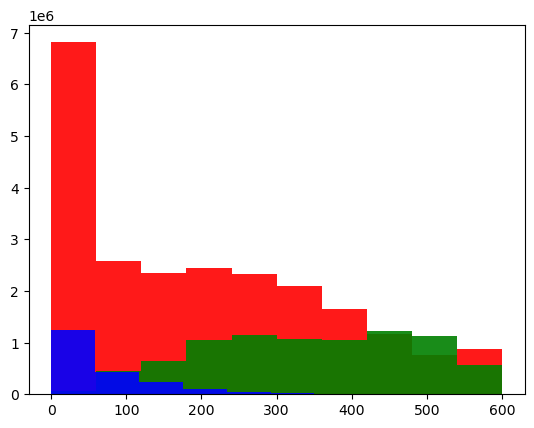

In [16]:
for sample in train_dataloader:
    image_s2, image_s1, target = sample['image_s2'].numpy(), sample['image_s1'].numpy(), sample['label'].numpy()
    plt.hist(image_s2.flatten(), color='r', alpha=0.9)
    plt.hist(image_s1.flatten(), color='g', alpha=0.9)
    plt.hist(target.flatten(), color='b', alpha=0.9)
    plt.show()
    break

(array([5.00000e+00, 1.92000e+02, 4.70800e+03, 9.67880e+04, 1.38561e+06,
        5.65798e+05, 4.16430e+04, 2.26900e+03, 1.29000e+02, 1.00000e+01]),
 array([-55.22138977, -43.7733345 , -32.32527542, -20.87722015,
         -9.42916393,   2.01889229,  13.46694851,  24.91500473,
         36.36306   ,  47.81111908,  59.25917435]),
 <BarContainer object of 10 artists>)

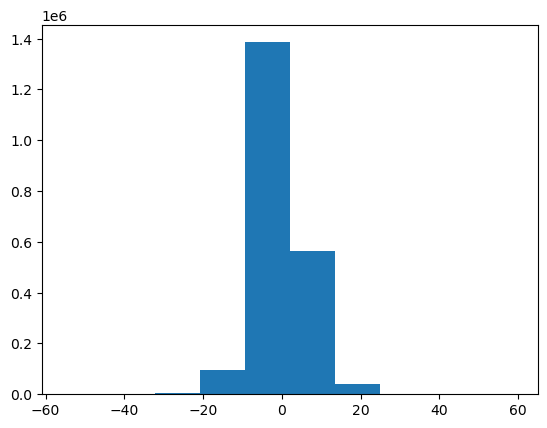

In [20]:
x = torch.Tensor(image_s2)
x = model(x).detach().numpy().flatten()
plt.hist(x)

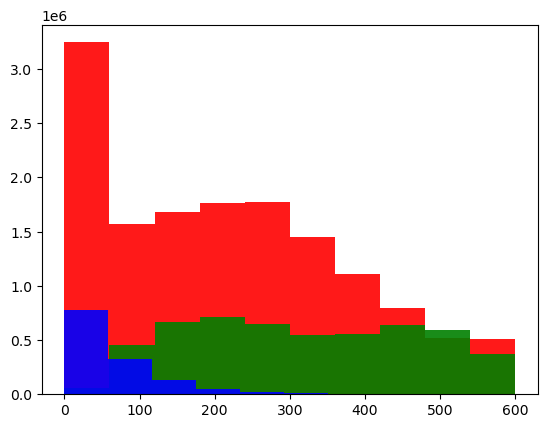

In [15]:
for sample in val_dataloader:
    image_s2, image_s1, target = sample['image_s2'].numpy(), sample['image_s1'].numpy(), sample['label'].numpy()
    plt.hist(image_s2.flatten(), color='r', alpha=0.9)
    plt.hist(image_s1.flatten(), color='g', alpha=0.9)
    plt.hist(target.flatten(), color='b', alpha=0.9)
    plt.show()
    break

# Trick 3: Detecting Anomalies in the Forward Pass

https://www.pytorchlightning.ai/blog/3-simple-tricks-that-will-change-the-way-you-debug-pytorch

The idea is simple: If we change the n-th input sample, it should only have an effect on the n-th output. If other outputs i ≠ n also change, the model mixes data and that’s not good! A reliable way to implement this test is to compute the gradient on the n-th output with respect to all inputs. The gradient must be zero for all i ≠ n (red in the animation above) and nonzero for i = n (green in the animation above). If these conditions are met, the model passes the test. Below is the implementation for n = 3:

In [24]:
# examine the gradient of the n-th minibatch sample w.r.t. all inputs
n = 0  

# 1. require gradient on input batch
example_input = torch.rand_like(torch.Tensor(image_s2), requires_grad=True)

# 2. run batch through model
output = model(example_input)

# 3. compute a dummy loss on n-th output sample and back-propagate
output[n].abs().sum().backward()

# 4. check that gradient on samples i != n are zero!
# sanity check: if this does not return 0, you have a bug!
i = 0
example_input.grad[i].abs().sum().item()

6107.4013671875

In [38]:
# examine the gradient of the n-th minibatch sample w.r.t. all inputs
n = 0

# 1. require gradient on input batch
example_input = torch.rand_like(torch.Tensor(image_s2), requires_grad=True)

# 2. run batch through model
output = model(example_input)

# 3. compute a dummy loss on n-th output sample and back-propagate
output[n].abs().sum().backward()

# 4. check that gradient on samples i != n are zero!
# sanity check: if this does not return 0, you have a bug!
zero_grad_inds = list(range(example_input.size(0)))     
zero_grad_inds.pop(n)


if example_input.grad[zero_grad_inds].abs().sum().item() > 0:
    raise RuntimeError("Your model mixes data across the batch dimension!")